# Camera Calibration 
## Method
### Zhang's Method for Camera Calibration

Zhang’s method, developed by Zhengyou Zhang, is an efficient technique for calibrating a camera using a flat calibration object, such as a checkerboard pattern. This method is popular due to its simplicity, accuracy, and the fact that it does not require complex 3D objects or specialized equipment. Instead, it relies on capturing multiple images of a planar pattern from various orientations, making it widely applicable in real-world scenarios.

\subsection*{1. Mathematical Model of the Camera}

In Zhang’s approach, the camera model is decomposed into intrinsic and extrinsic parameters:
- \textbf{Intrinsic Parameters} define the camera's internal characteristics:
  
  $$
  \mathbf{K} = \begin{bmatrix} f_x & s & c_x \\ 0 & f_y & c_y \\ 0 & 0 & 1 \end{bmatrix}
  $$

  where:
  - $f_x$ and $f_y$ are the focal lengths in pixels,
  - $(c_x, c_y)$ is the principal point, and
  - $s$ is the skew coefficient (often close to zero for most cameras).
  
- \textbf{Extrinsic Parameters} describe the rotation and translation between the camera and the world coordinate system:

  $$
  \mathbf{P} = \mathbf{K} [\mathbf{R} \,|\, \mathbf{t}]
  $$

  where $\mathbf{R}$ is the rotation matrix and $\mathbf{t}$ is the translation vector.

\subsection*{2. Homography-Based Initial Estimation}

For each view of the checkerboard, the 3D world coordinates $(X_w, Y_w, 0)$ reduce to 2D coordinates on the plane. The relationship between the world points $\mathbf{X}_w = (X_w, Y_w, 1)^T$ and the corresponding 2D image points $\mathbf{x} = (x, y, 1)^T$ is captured by a \textbf{homography matrix} $\mathbf{H}$ such that:

$$
\mathbf{x} = \mathbf{H} \mathbf{X}_w
$$

For each view, the homography $\mathbf{H}$ relates the planar world coordinates to the 2D image coordinates and can be expressed as:

$$
\mathbf{H} = \mathbf{K} [\mathbf{r}_1 \, \mathbf{r}_2 \, \mathbf{t}]
$$

where $\mathbf{r}_1$ and $\mathbf{r}_2$ are the first two columns of the rotation matrix $\mathbf{R}$. Given that $\mathbf{r}_1$ and $\mathbf{r}_2$ are orthogonal unit vectors, we derive the following constraints:

$$
\mathbf{h}_1^T \mathbf{K}^{-T} \mathbf{K}^{-1} \mathbf{h}_2 = 0
$$
$$
\mathbf{h}_1^T \mathbf{K}^{-T} \mathbf{K}^{-1} \mathbf{h}_1 = \mathbf{h}_2^T \mathbf{K}^{-T} \mathbf{K}^{-1} \mathbf{h}_2
$$

where $\mathbf{h}_1$ and $\mathbf{h}_2$ are the columns of $\mathbf{H}$. By accumulating these constraints across multiple views of the calibration pattern, we obtain a system of linear equations.

\subsection*{3. Estimating the Intrinsic Matrix $\mathbf{K}$}

With at least three views of the pattern, we form a matrix system:

$$
\mathbf{V} \mathbf{b} = 0
$$

where $\mathbf{V}$ is a matrix built from the constraints, and $\mathbf{b}$ is a vector representing elements of $\mathbf{K}^{-T} \mathbf{K}^{-1}$. Solving for $\mathbf{b}$ yields an estimate for the intrinsic matrix $\mathbf{K}$, from which the intrinsic parameters $f_x$, $f_y$, $s$, $c_x$, and $c_y$ can be extracted.

\subsection*{4. Determining Extrinsic Parameters}

Once $\mathbf{K}$ is estimated, each homography matrix $\mathbf{H}$ provides the extrinsic parameters $\mathbf{R}$ and $\mathbf{t}$ for that view as follows:

$$
\mathbf{r}_1 = \lambda \mathbf{K}^{-1} \mathbf{h}_1, \quad \mathbf{r}_2 = \lambda \mathbf{K}^{-1} \mathbf{h}_2, \quad \mathbf{t} = \lambda \mathbf{K}^{-1} \mathbf{h}_3
$$

where $\lambda$ is a scaling factor, and $\mathbf{h}_1, \mathbf{h}_2, \mathbf{h}_3$ are the columns of $\mathbf{H}$. The rotation matrix $\mathbf{R}$ is obtained by orthonormalizing $\mathbf{r}_1$ and $\mathbf{r}_2$.

## Advantages of using cheaker board pattern

1. High contrast between black and white squares allows for precise corner detection.
2. Well-defined square corners enable subpixel accuracy in locating key points.
3. Simple 2D planar structure reduces model complexity and simplifies homography calculations.
4. Easily available and reproducible, making calibration setup convenient.
5. Portable, allowing capture from multiple views to improve calibration robustness.





In [1]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
import os

def calibrate_camera(calibration_dir_path, save_matrix_path="K.txt"):
    calibration_images = glob.glob(calibration_dir_path)
    chessboard_size = (8, 6)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 24, 0.001)

    objp = np.zeros((chessboard_size[0] * chessboard_size[1], 3), np.float32)
    objp[:, :2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1, 2)

    objpoints, imgpoints = [], []
    gray, w, h = None, None, None
    image_names = []

    for i, fname in enumerate(calibration_images, start=1):
        img = cv2.imread(fname)
        if img is None:
            print(f"Warning: Could not read image {fname}. Skipping.")
            continue
        
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        h, w = img.shape[:2]

        ret, corners = cv2.findChessboardCorners(gray, chessboard_size, None)

        if ret:
            objpoints.append(objp)
            corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
            imgpoints.append(corners2)
            image_names.append(os.path.basename(fname))

            img_with_corners = cv2.drawChessboardCorners(img, chessboard_size, corners2, ret)
            img_rgb = cv2.cvtColor(img_with_corners, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(6, 5))
            plt.imshow(img_rgb)
            plt.title(f"Chessboard Corners: {os.path.basename(fname)}")
            plt.axis('off')
            plt.tight_layout()
            plt.show()
    
    if objpoints and imgpoints:
        ret, K, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        K_undist, roi = cv2.getOptimalNewCameraMatrix(K, dist, (w, h), 1, (w, h))

        print("✅ Calibration successful!")
        print("\nCamera Intrinsic Matrix (K):\n", K)
        print("\nDistortion Coefficients:\n", dist.ravel())
        print("\nNew Undistorted Camera Matrix:\n", K_undist)

        # Save K_undist to file
        np.savetxt(save_matrix_path, K_undist, fmt="%.8f")
        print(f"\n📁 Saved K_undist to '{save_matrix_path}'")

        # Compute and plot reprojection errors
        total_error = 0
        per_view_errors = []

        for i in range(len(objpoints)):
            imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], K, dist)
            error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2) / len(imgpoints2)
            per_view_errors.append(error)
            total_error += error

        avg_error = total_error / len(objpoints)
        print(f"\nMean Reprojection Error: {avg_error:.4f} pixels")

        plt.figure(figsize=(8, 5))
        plt.bar(range(len(per_view_errors)), per_view_errors, tick_label=image_names)
        plt.xticks(rotation=45, ha='right')
        plt.ylabel("Reprojection Error (pixels)")
        plt.title("Per-Image Reprojection Error")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        return K, dist, K_undist
    else:
        print("\n❌ No chessboard corners were detected in the images. Calibration failed.")
        return None, None, None


Found 28 images in folder './cal1/*.png'.


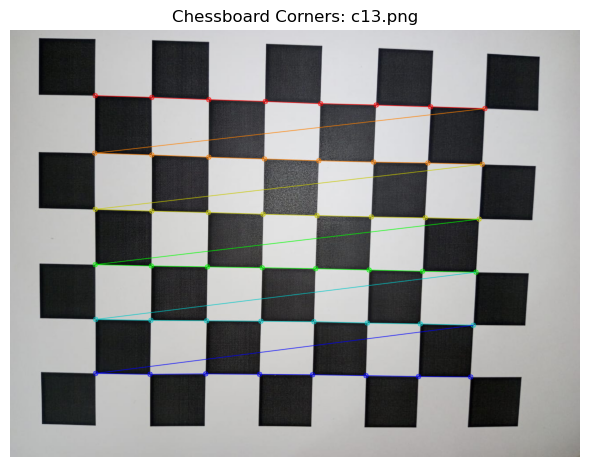

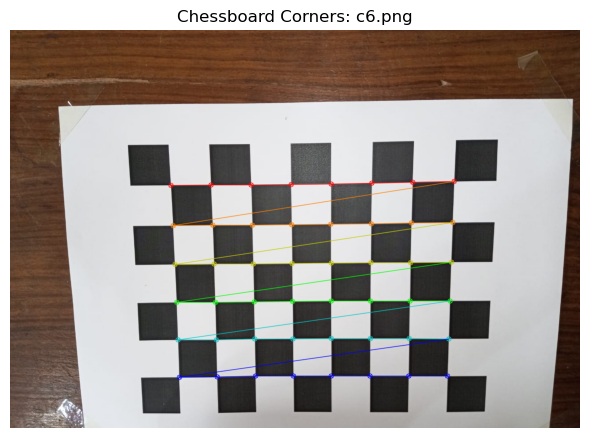

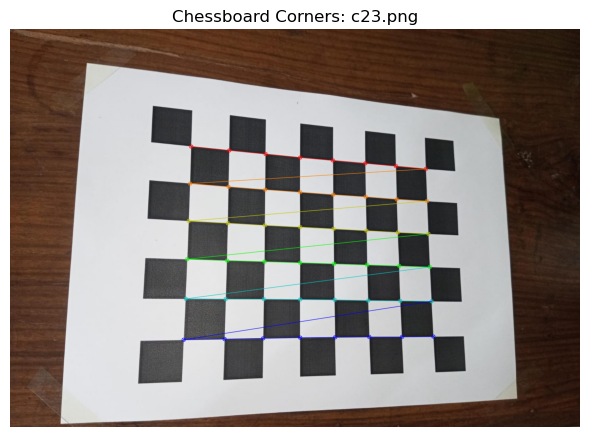

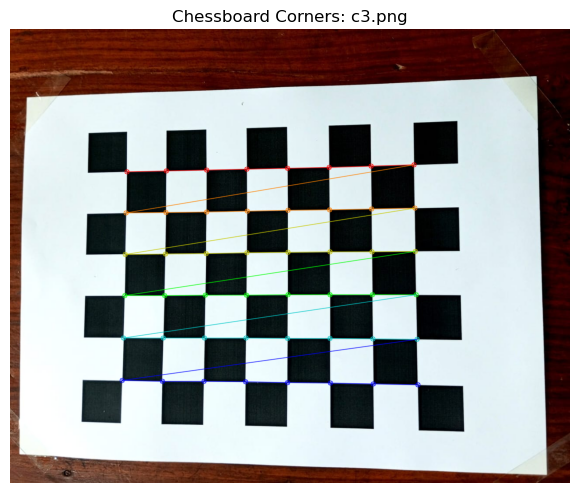

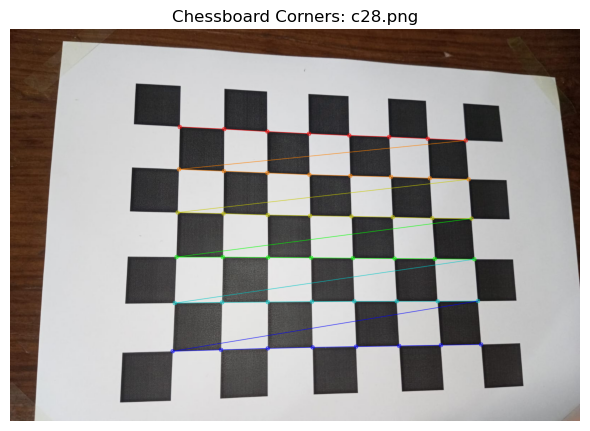

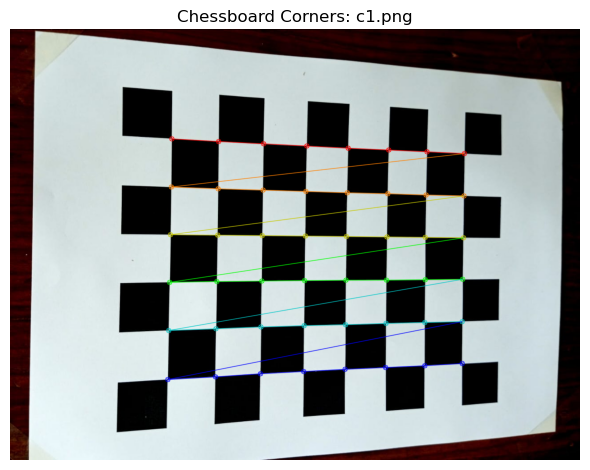

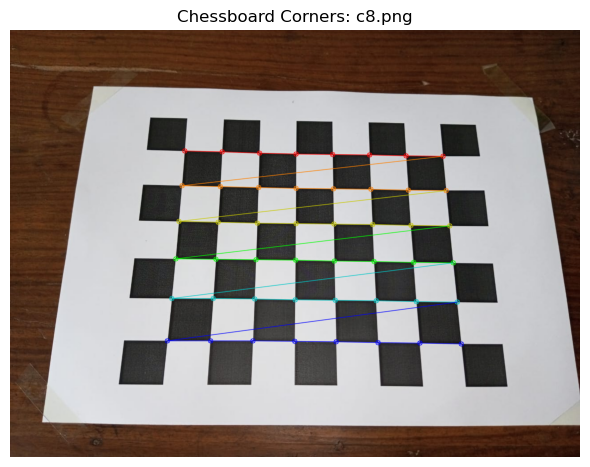

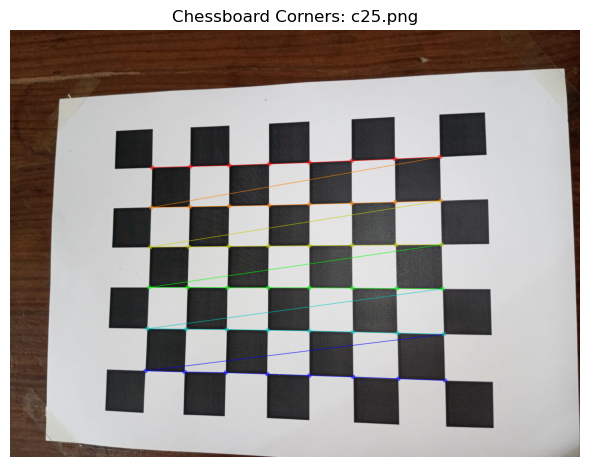

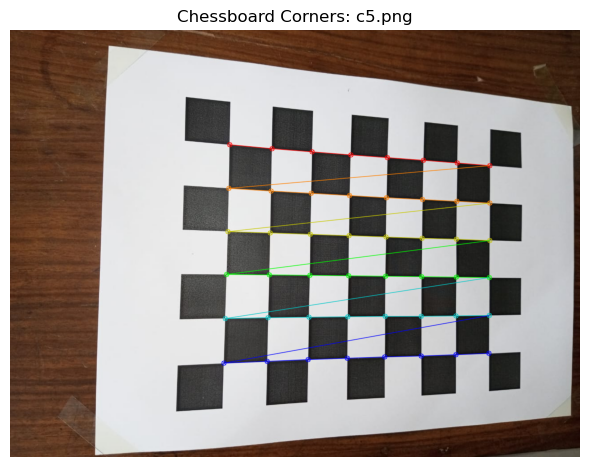

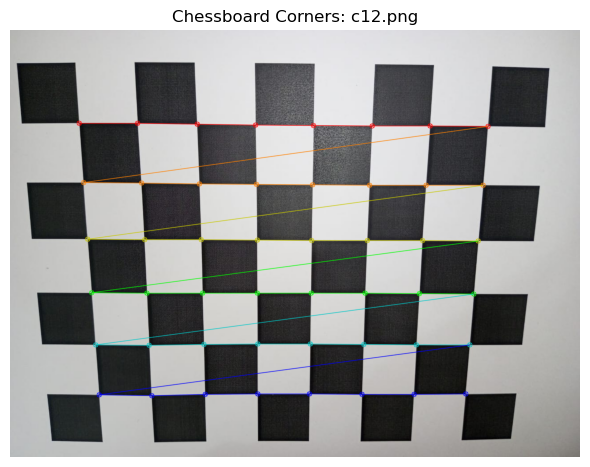

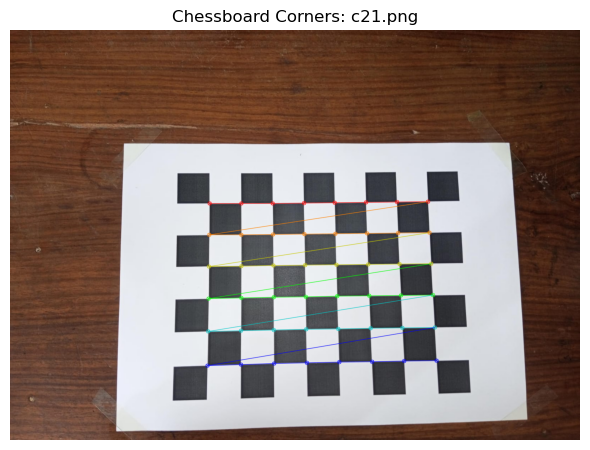

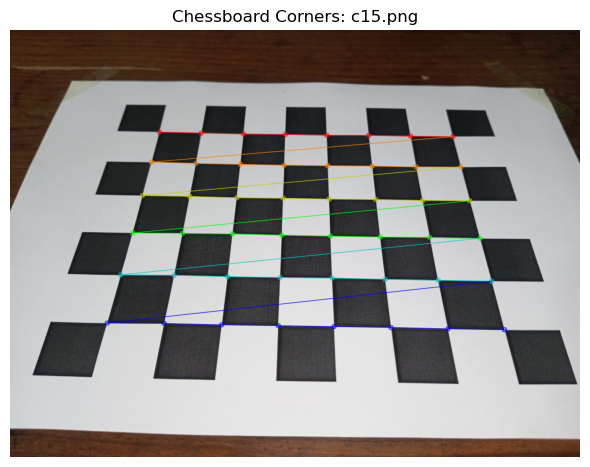

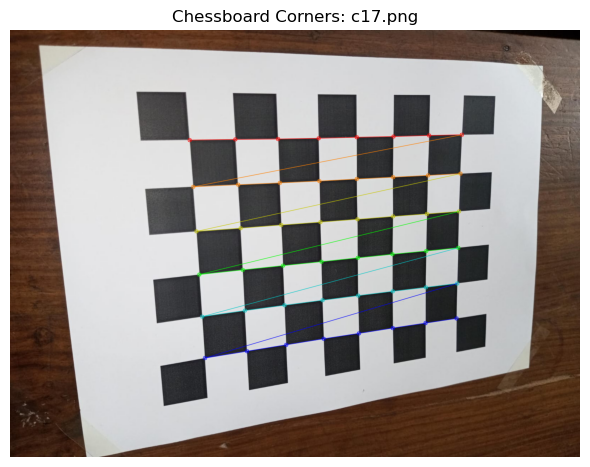

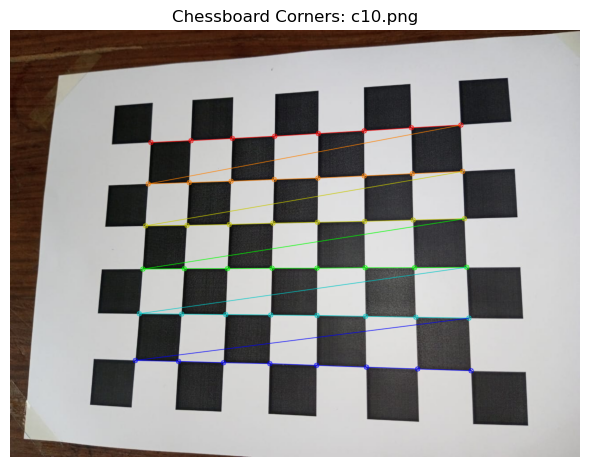

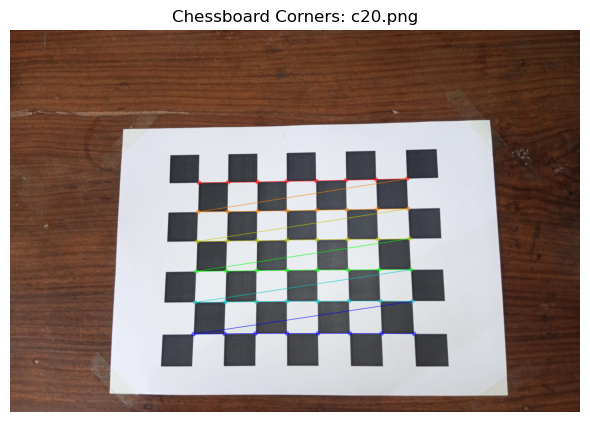

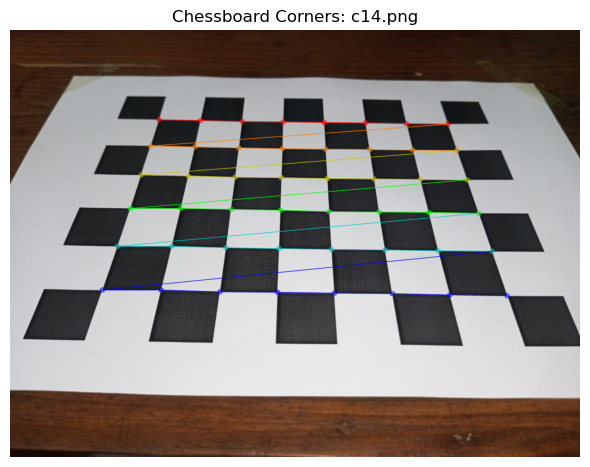

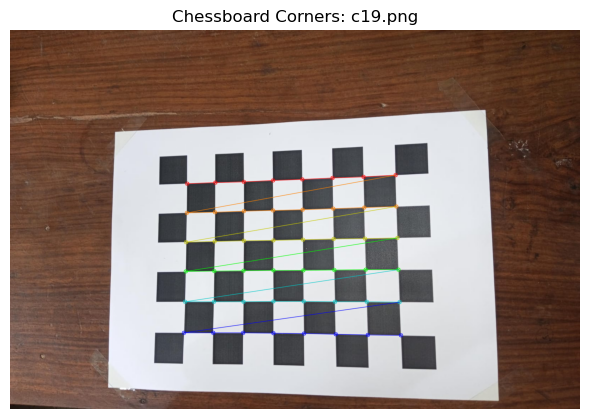

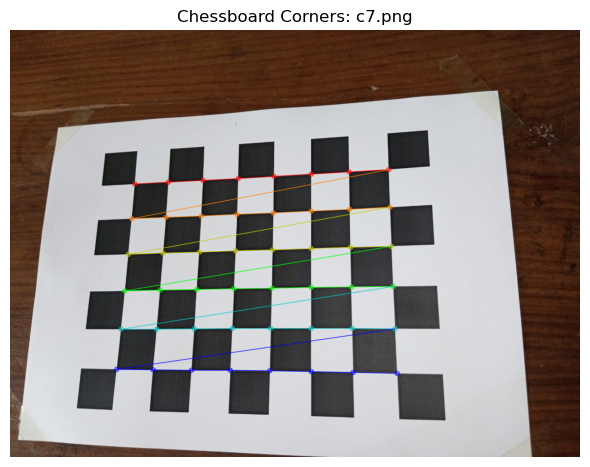

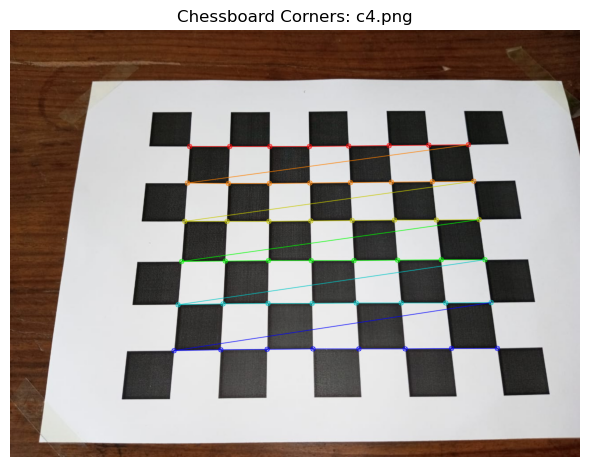

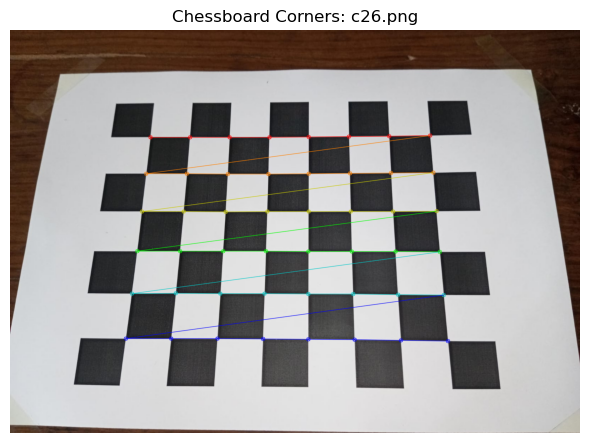

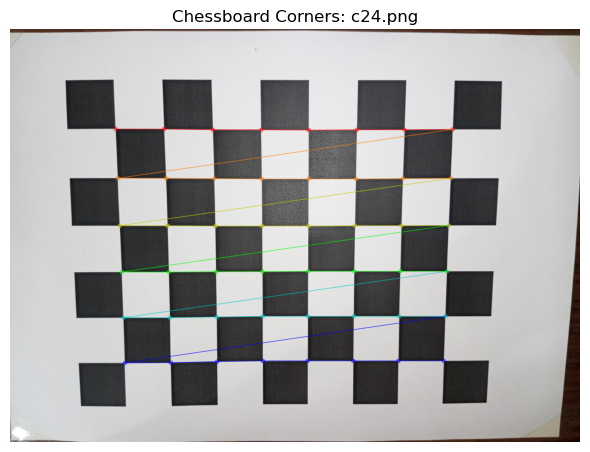

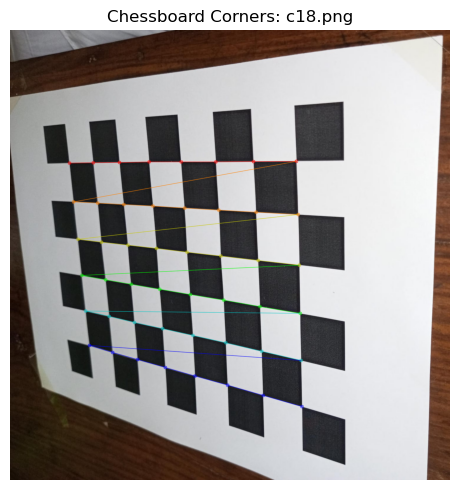

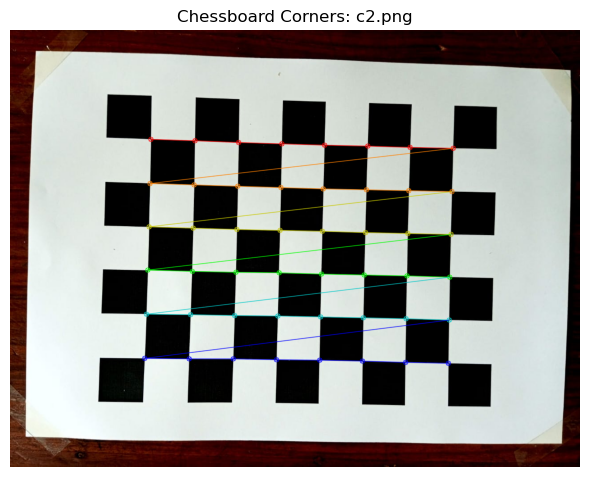

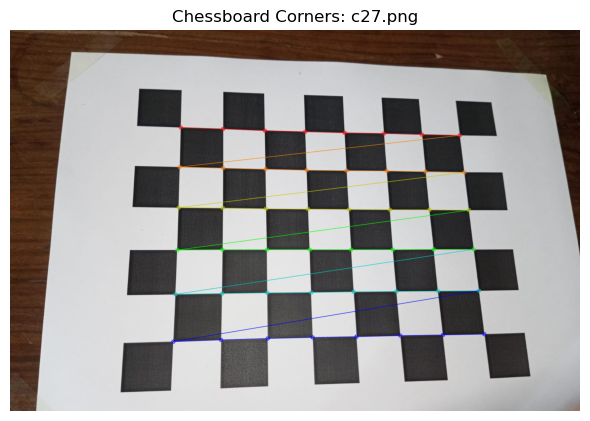

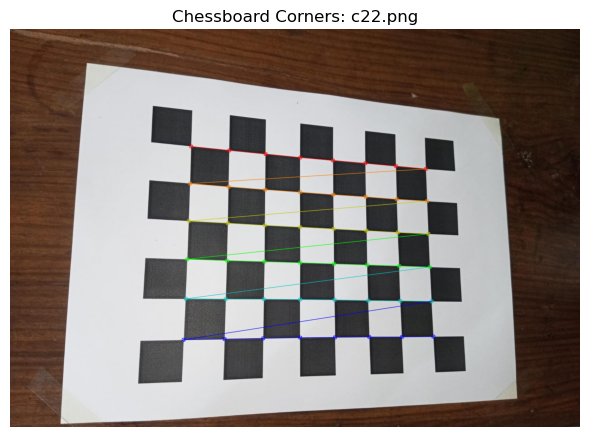

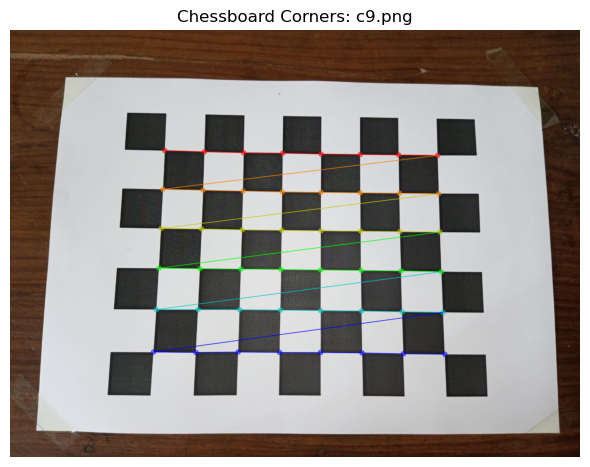

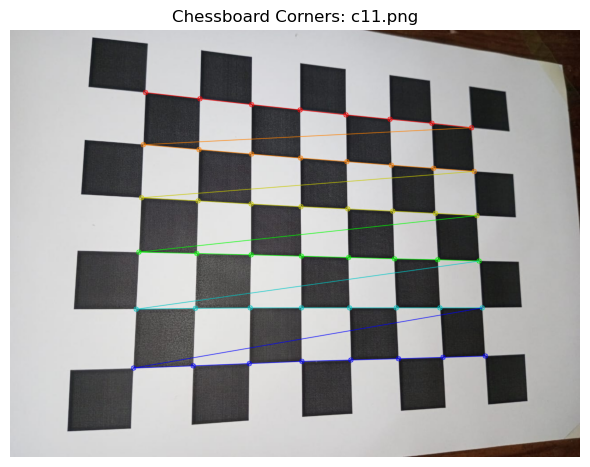

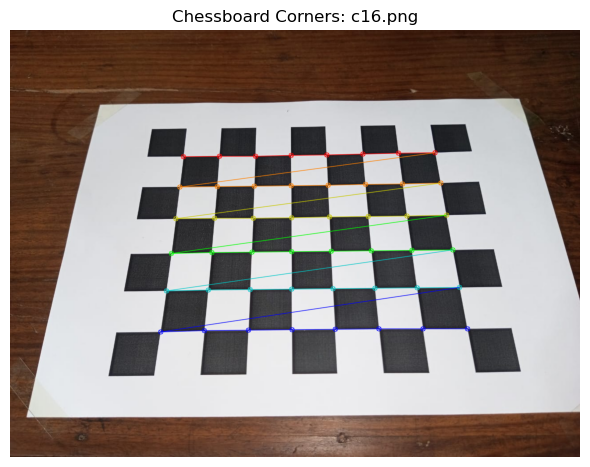

✅ Calibration successful!

Camera Intrinsic Matrix (K):
 [[1.46013877e+03 0.00000000e+00 7.15244886e+02]
 [0.00000000e+00 1.46555320e+03 4.62029182e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Distortion Coefficients:
 [-0.0259759   0.15992414 -0.0019859  -0.00385389 -1.09540281]

New Undistorted Camera Matrix:
 [[1.40630435e+03 0.00000000e+00 7.21827948e+02]
 [0.00000000e+00 1.40340401e+03 4.57655555e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

📁 Saved K_undist to './K.txt'

Mean Reprojection Error: 0.4896 pixels


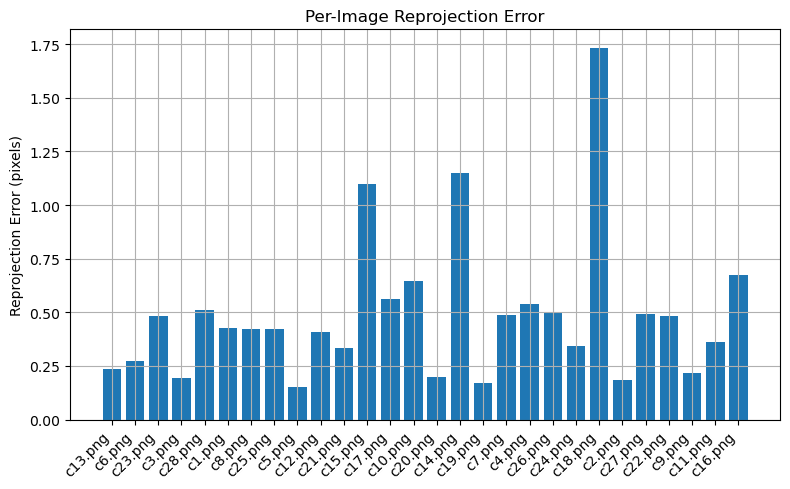

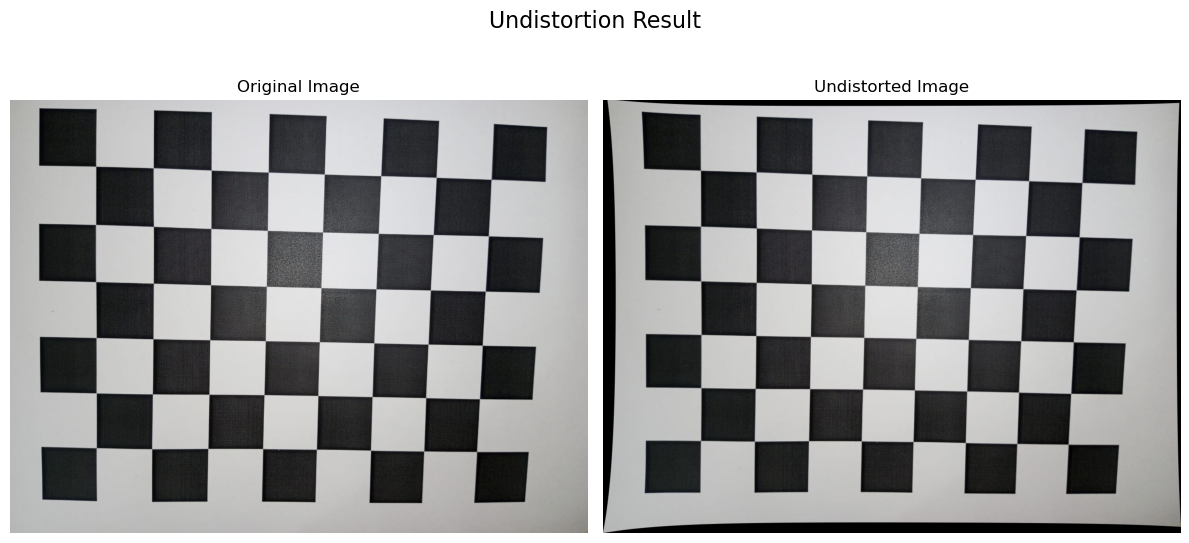

In [2]:

# ------------------------------------------------------------------------------
# DRIVER CODE
# ------------------------------------------------------------------------------

if __name__ == "__main__":
    calibration_dir = './cal1/*.png'  # Or '*.jpg' if needed
    save_path = './K.txt'

    image_paths = glob.glob(calibration_dir)
    print(f"Found {len(image_paths)} images in folder '{calibration_dir}'.")

    if len(image_paths) == 0:
        print("❌ No calibration images found. Please check the path.")
    else:
        K, dist, K_undist = calibrate_camera(calibration_dir, save_matrix_path=save_path)

        if K is not None:
            sample_img_path = image_paths[0]
            img = cv2.imread(sample_img_path)
            undistorted = cv2.undistort(img, K, dist, None, K_undist)

            fig, axs = plt.subplots(1, 2, figsize=(12, 6))
            axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            axs[0].set_title("Original Image")
            axs[0].axis("off")

            axs[1].imshow(cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB))
            axs[1].set_title("Undistorted Image")
            axs[1].axis("off")

            plt.suptitle("Undistortion Result", fontsize=16)
            plt.tight_layout()
            plt.show()
        else:
            print("🛑 Calibration failed. Undistortion skipped.")